## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib

pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online
data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

In [3]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [4]:
# replace interrogation marks by NaN values
data = data.replace('?', np.nan)

In [5]:
# retain only the first cabin if more than 1 are available per passenger
def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [6]:
# extracts the title (Mr, Ms, etc) from the name variable
def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [7]:
# cast numerical variables as floats
data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [8]:
# drop unnecessary variables
data.drop(labels=['name', 'ticket', 'boat', 'body', 'home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [9]:
# save the data set
data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [10]:
target = 'survived'

In [11]:
vars_num = [v for v in data.columns if data[v].dtype != 'O' and v != target]
vars_cat = [v for v in data.columns if data[v].dtype == 'O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


In [12]:
vars_num

['pclass', 'age', 'sibsp', 'parch', 'fare']

### Find missing values in variables

In [13]:
# first in numerical variables
data[vars_num].isnull().astype(int).sum(axis=0) / len(data)

pclass    0.000000
age       0.200917
sibsp     0.000000
parch     0.000000
fare      0.000764
dtype: float64

In [14]:
# now in categorical variables
data[vars_cat].isnull().astype(int).sum(axis=0) / len(data)

sex         0.000000
cabin       0.774637
embarked    0.001528
title       0.000000
dtype: float64

### Determine cardinality of categorical variables

In [15]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

In [16]:
data[vars_num].nunique()

pclass      3
age        98
sibsp       7
parch       8
fare      281
dtype: int64

### Determine the distribution of numerical variables

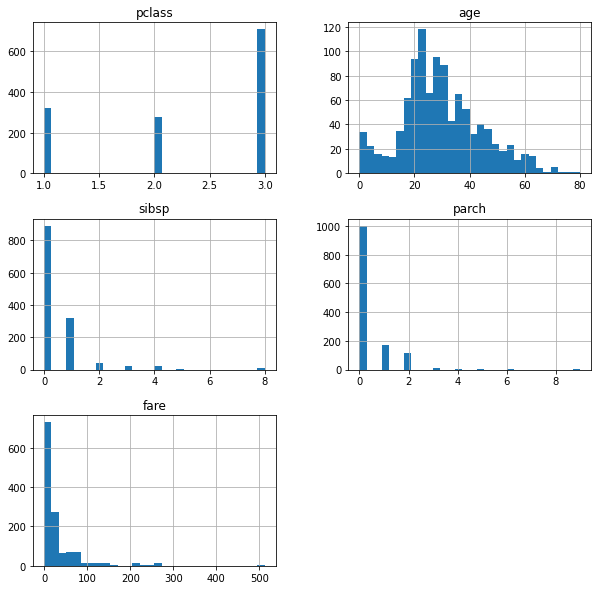

In [17]:
data[vars_num].hist(bins=30, figsize=(10, 10))
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility
    
X_train.shape, X_test.shape

((1047, 9), (262, 9))

In [19]:
gender_baseline = X_test.sex.map({'male':1, 'female':0}).values

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [20]:
def get_cabin_first_letter(cabin):
    if pd.isna(cabin):
        return cabin
    else:
        return cabin[0]

X_train['cabin'] = X_train['cabin'].apply(get_cabin_first_letter)
X_test['cabin'] = X_test['cabin'].apply(get_cabin_first_letter)

In [21]:
X_train.cabin.unique()

array([nan, 'E', 'F', 'A', 'C', 'D', 'B', 'T', 'G'], dtype=object)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [22]:
X_test.isnull().sum()

pclass        0
sex           0
age          57
sibsp         0
parch         0
fare          0
cabin       211
embarked      0
title         0
dtype: int64

In [23]:
X_train.isnull().sum()

pclass        0
sex           0
age         206
sibsp         0
parch         0
fare          1
cabin       803
embarked      2
title         0
dtype: int64

In [24]:
for var in vars_num:
    if X_train[var].isnull().sum() + X_test[var].isnull().sum() == 0:
        continue
    else:
        # indicators
        X_train[f'{var}_na'] = np.where(X_train[var].isnull(), 1, 0)
        X_test[f'{var}_na'] = np.where(X_test[var].isnull(), 1, 0)

        # imputation
        train_median = X_train[var].median()    
        X_train[var] = X_train[var].fillna(train_median)
        X_test[var]  = X_test[var].fillna(train_median)

In [25]:
X_train

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.0000,0,0,7.9250,NaN,S,Mr,0,0
44,1,female,41.0000,0,0,134.5000,E,C,Miss,0,0
1072,3,male,28.0000,0,0,7.7333,NaN,Q,Mr,1,0
1130,3,female,18.0000,0,0,7.7750,NaN,S,Miss,0,0
574,2,male,29.0000,1,0,21.0000,NaN,S,Mr,0,0
...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,NaN,S,Miss,0,0
835,3,male,28.0000,0,0,8.0500,NaN,S,Mr,1,0
1216,3,female,28.0000,0,0,7.7333,NaN,Q,Miss,1,0
559,2,female,20.0000,0,0,36.7500,NaN,S,Miss,0,0


### Replace Missing data in categorical variables with the string **Missing**

In [26]:
for var in vars_cat:
    X_train[var] = X_train[var].fillna("Missing")
    X_test[var]  = X_test[var].fillna("Missing")

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [27]:
def rare_labels(var, rare_perc=0.05):
    tmp = X_train.groupby(var).pclass.count() / len(X_train)
    return tmp[tmp <= rare_perc].index.tolist()

for var in vars_cat:
    X_train[var] = np.where(X_train[var].isin(rare_labels(var)), 'Rare', X_train[var])
    X_test[var] = np.where(X_test[var].isin(rare_labels(var)), 'Rare', X_test[var])


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [28]:
for var in vars_cat:
    k = X_train[var].nunique()
    for label in X_train[var].unique()[:k-1]:
        X_train[f'{var}_{label}'] = np.where(X_train[var]==label, 1, 0)
        X_test[f'{var}_{label}'] = np.where(X_test[var]==label, 1, 0)

In [29]:
X_train.drop(vars_cat, inplace=True, axis=1)
X_test.drop(vars_cat, inplace=True, axis=1)

In [30]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_male,cabin_Missing,cabin_Rare,embarked_S,embarked_C,embarked_Q,title_Mr,title_Miss,title_Mrs
1118,3,25.0,0,0,7.9250,0,0,1,1,0,1,0,0,1,0,0
44,1,41.0,0,0,134.5000,0,0,0,0,1,0,1,0,0,1,0
1072,3,28.0,0,0,7.7333,1,0,1,1,0,0,0,1,1,0,0
1130,3,18.0,0,0,7.7750,0,0,0,1,0,1,0,0,0,1,0
574,2,29.0,1,0,21.0000,0,0,1,1,0,1,0,0,1,0,0


In [31]:
X_test.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_male,cabin_Missing,cabin_Rare,embarked_S,embarked_C,embarked_Q,title_Mr,title_Miss,title_Mrs
1139,3,38.0,0,0,7.8958,0,0,1,1,0,1,0,0,1,0,0
533,2,21.0,0,1,21.0000,0,0,0,1,0,1,0,0,0,1,0
459,2,42.0,1,0,27.0000,0,0,1,1,0,1,0,0,1,0,0
1150,3,28.0,0,0,14.5000,1,0,1,1,0,1,0,0,1,0,0
393,2,25.0,0,0,31.5000,0,0,1,1,0,1,0,0,1,0,0


In [32]:
X_train.columns.tolist() == X_test.columns.tolist()

True

### Scale the variables

- Use the standard scaler from Scikit-learn

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [34]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=0.0005, random_state=0)
model.fit(X_train, y_train)

LogisticRegression(C=0.0005, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [35]:
from sklearn.metrics import roc_auc_score, accuracy_score

print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
print(accuracy_score(y_test, model.predict(X_test)))

0.8389197530864198
0.6984732824427481


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**